In [28]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

import matplotlib.pyplot as plt

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../../pompjax/pompjax/")
sys.path.insert(0, "../..")
sys.path.insert(0, "../")

from global_config import config

results_dir          = config.get_property('results_dir')
results2_dir         = config.get_property('results2_dir')
data_dir             = config.get_property('data_dir')
paper_dir            = config.get_property('paper_dir')
data_db_dir          = config.get_property('data_db_dir')

data_cluster_dir     = config.get_property('data_cluster_dir')
results_cluster_dir  = config.get_property('results_cluster_dir')

feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")


In [29]:
from utils_local import plot_utils
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
import seaborn as sns

path_to_results = "/Users/chaosdonkey06/Dropbox/shaman-lab/amr-hospitals2/results"
path_to_results = os.path.join(path_to_results, "covid19_sensitivity", "no_readmission")


In [30]:

####-####-####-####-####-####-####-####-####-####-####
amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
                'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

ignore_dates                    = np.arange(0, 16+2, 2)

experiments_df                  = pd.DataFrame(columns=["amro", "dates_ignored"])
experiments_df["dates_ignored"] = list(ignore_dates)*len(amro_search)
experiments_df["amro"]          = flatten_list([[amro]*len(ignore_dates) for amro in amro_search])
experiments_df["scenario"]      = list(np.arange(len(ignore_dates))+1)*len(amro_search)
experiments_df["scenario"]      = experiments_df["scenario"].apply(lambda x: f"scenario{x-1}")


In [31]:

def empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv"):
    amro_prev_df = pd.read_csv(path_to_prev)
    gammas       = amro_prev_df[amro_prev_df.amro==amro][["prevalence_mean1", "prevalence_mean2", "prevalence_mean3"]].values / 100
    return np.squeeze(gammas)

In [32]:
from utils_local.misc import amro2title, amro2cute

θ_all = np.full((len(amro_search), 9, 3, 2, 300), np.nan)
Nif   = 30

id_run       = 0
posterior_df = pd.DataFrame()

for i_row, row in experiments_df.iterrows():
    amro            = row.amro

    for idx_prev in range(3):
        samples_path    = os.path.join(path_to_results, amro2cute(amro), row.scenario)
        path_to_samples = os.path.join(samples_path, f"prevalence{idx_prev+1}", "000posterior.npz")

        if not os.path.exists(path_to_samples):
            continue

        inference = np.load(path_to_samples)
        θpost     = inference["posterior"]
        Nif       = θpost.shape[-1]

        ρ_post = θpost[0, :, :, :].mean(-2).flatten()
        β_post = θpost[1, :, :, :].mean(-2).flatten()

        amro_index = amro_search.index(row.amro)
        i_date     = np.where(row.dates_ignored==ignore_dates)[0][0]

        θ_all[amro_index, i_date, idx_prev, 0, :] = θpost[0, :, :, :].mean(-2)[:, -1] * 100
        θ_all[amro_index, i_date, idx_prev, 1, :] = θpost[1, :, :, :].mean(-2)[:, -1]

        gammas = empirical_prevalence(amro, path_to_prev="../../data/amro_prevalence.csv")

        post_df                  = pd.DataFrame(columns=["value", "param", "ens_id", "if_iter"])
        post_df["value"]         = np.concatenate([ρ_post, β_post])
        post_df["param"]         = ["ρ"] * len(ρ_post) + ["β"] * len(β_post)
        post_df["if_iter"]       = flatten_list([list(range(Nif)) * 300  ] * 2 )
        post_df["ens_id"]        = flatten_list([[i] * Nif for i in range( 300 )] * 2)
        post_df["gamma"]         = gammas[idx_prev]
        post_df["skipped_dates"] = row.dates_ignored
        post_df["amro"]          = row.amro
        posterior_df             = pd.concat([posterior_df, post_df])

v_df = posterior_df[posterior_df["if_iter"] == Nif-1]


In [33]:
ignore_dates

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16])

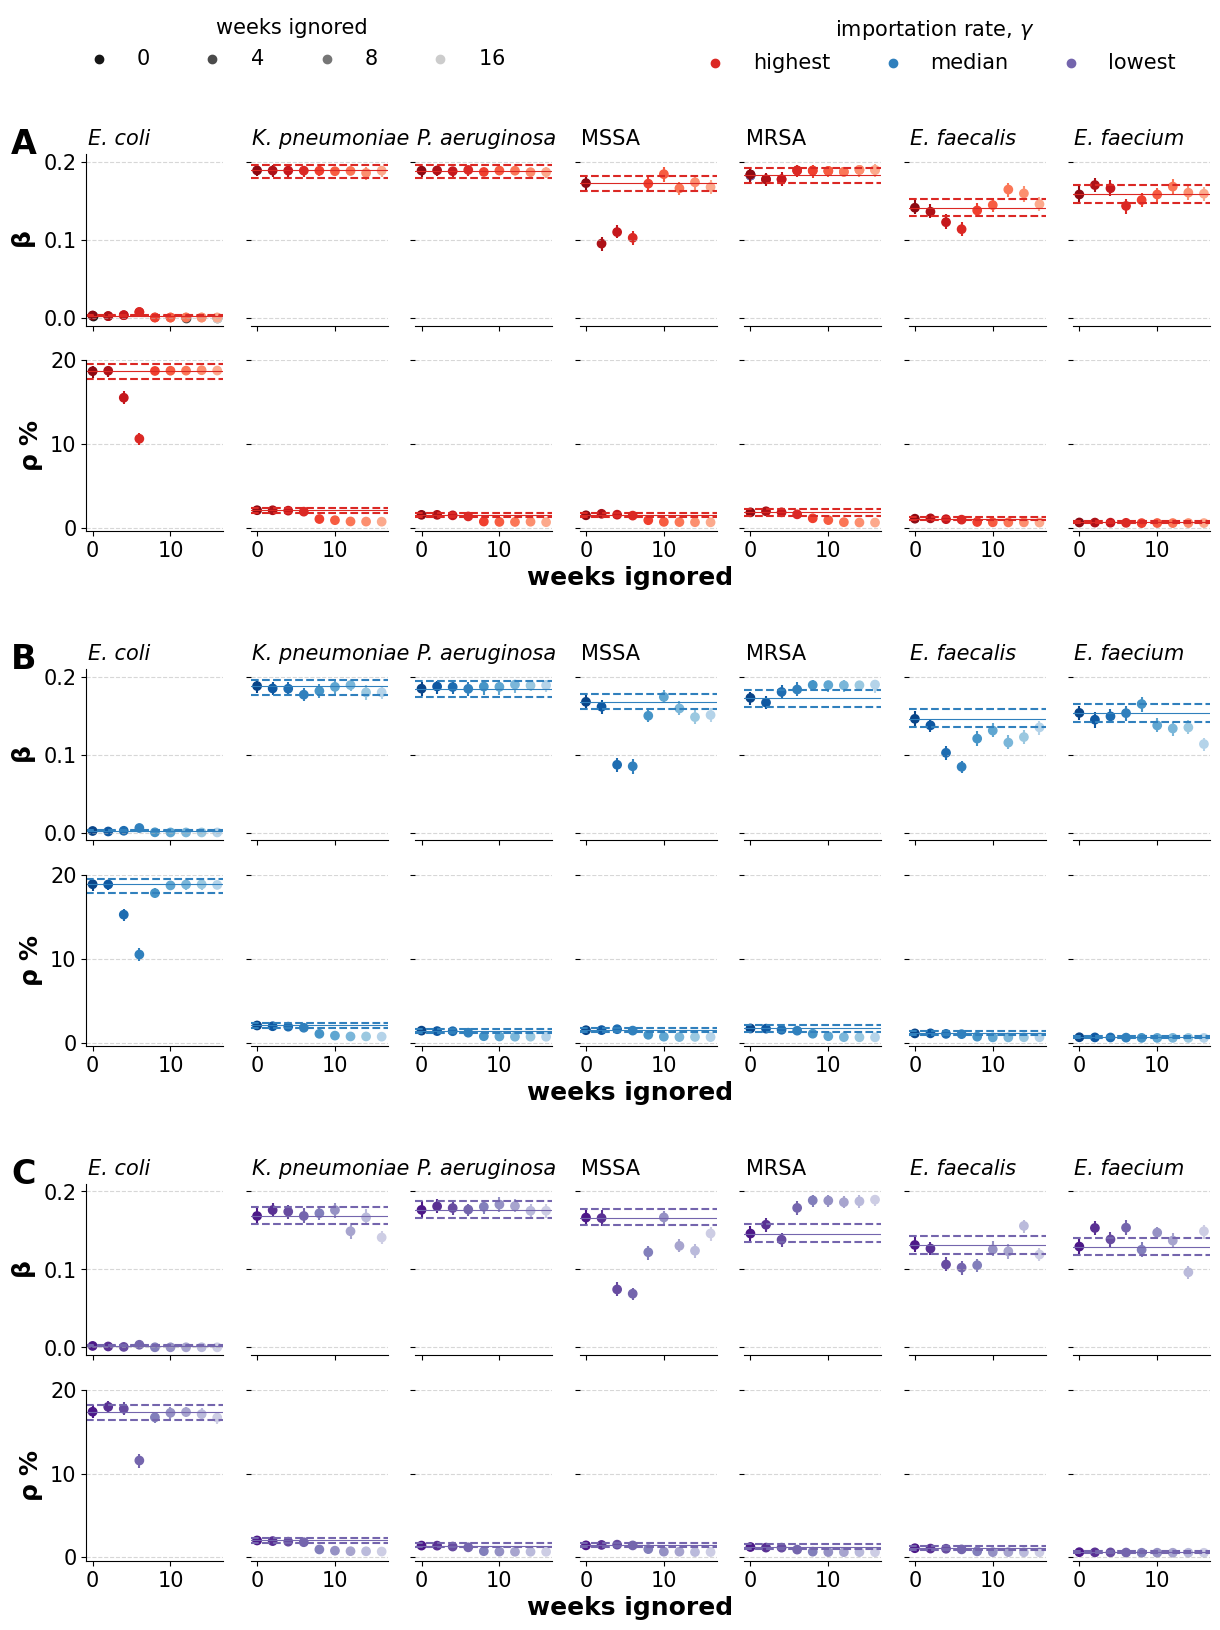

In [34]:
from utils_local.misc import amro2title, amro2cute
COLORS_GAMMA1 = sns.color_palette("Purples_r", len(ignore_dates)+3)[:-3]# sns.color_palette("Purples_r ", len(ignore_dates)+3)[:-3]
COLORS_GAMMA2 = sns.color_palette("Blues_r", len(ignore_dates)+3)[:-3]
COLORS_GAMMA3 = sns.color_palette("Reds_r", len(ignore_dates)+3)[:-3]

COLORS = [COLORS_GAMMA1, COLORS_GAMMA2, COLORS_GAMMA3]

fig      = plt.figure(constrained_layout=False, figsize=(14.5, 15.2))
subfigs  = fig.subfigures(3, 1, hspace=0.05, wspace=0.05, height_ratios=[1/3, 1/3, 1/3])
axes_all = []

legend_char = ["A", "B", "C"]
index_order = [2, 1, 0]

for prev_idx in range(3):

    ax = subfigs[prev_idx].subplots(2, len(amro_search), sharex=True, sharey="row")
    axes_all.append(ax)

    char     = legend_char[prev_idx]
    prev_idx = index_order[prev_idx] # TO PLOT FROM UPPER TO LOWER

    θ_mean       = θ_all[:, :, prev_idx, :, :].mean(-1)
    COLORS_GAMMA = COLORS[prev_idx][:9]

    for i_amro, amro in enumerate(amro_search):
        y_axis = ignore_dates

        ### for ro
        quant = np.quantile(θ_all[i_amro, :, prev_idx, 0, :], q=[0.05, 0.95], axis=1)
        ax[1, i_amro].vlines(x   = y_axis,
                            ymin = quant[1, :],
                            ymax = quant[0, :], color=COLORS_GAMMA)

        ax[1, i_amro].scatter(y_axis, θ_mean[i_amro, :, 0], fc=COLORS_GAMMA, ec=None)

        ### for β ###
        quant = np.quantile(θ_all[i_amro, :, prev_idx, 1, :], q=[0.05, 0.95], axis=1)
        ax[0, i_amro].vlines(x   = y_axis,
                            ymin = quant[1, :],
                            ymax = quant[0, :], color=COLORS_GAMMA)
        ax[0, i_amro].scatter(y_axis, θ_mean[i_amro, :, 1], fc=COLORS_GAMMA, ec=None)

        ####-####-####-####-####-####-####-####-####-####-####
        posterior_ref = θ_all[i_amro, 0, prev_idx, :, :]
        mean_post_ref = θ_all[i_amro, 0, prev_idx, :, :].mean(-1)

        ##### plot original estimates as lines ####
        ## estimate for ro
        quants_ρ = np.quantile(posterior_ref[0,:], q=[0.025, 0.975])

        ax[1, i_amro].axhline(y=mean_post_ref[0], c=COLORS_GAMMA[3], linestyle="-", lw=0.8)
        ax[1, i_amro].axhline(y=quants_ρ[0], c=COLORS_GAMMA[3], linestyle="--")
        ax[1, i_amro].axhline(y=quants_ρ[1], c=COLORS_GAMMA[3], linestyle="--")

        ## estimate for beta
        quants_β = np.quantile(posterior_ref[1, :], q=[0.025, 0.975])

        ax[0, i_amro].axhline(y=mean_post_ref[1], c=COLORS_GAMMA[3], linestyle="-", lw=0.8)
        ax[0, i_amro].axhline(y=quants_β[0], c=COLORS_GAMMA[3], linestyle="--")
        ax[0, i_amro].axhline(y=quants_β[1], c=COLORS_GAMMA[3], linestyle="--")

    for axi in ax.flatten():
        axi.spines['right'].set_visible(False)
        axi.spines['top'].set_visible(False)

        axi.grid(axis="y", linestyle="--", alpha=0.5)

    for i_amro in range(1, len(amro_search)):
        ax[0, i_amro].spines["left"].set_visible(False)
        ax[1, i_amro].spines["left"].set_visible(False)

    for i_amro in range(len(amro_search)):
        if amro2title(amro_search[i_amro])!="MSSA" and amro2title(amro_search[i_amro])!="MRSA":
            style = "italic"
        else:
            style = "normal"
        ax[0, i_amro].text(s      = amro2title(amro_search[i_amro]),
                        x         = 0.01,
                        y         = 1.05,
                        transform = ax[0, i_amro].transAxes,
                        style     = style)

    ax[0, 0].text(s       = f"{char}",
                x         = -0.55,
                y         = 1.,
                transform = ax[0, 0].transAxes,
                weight    = "bold",
                fontsize  = 24)

    ax[0, 0].set_ylabel(r"$\mathbf{\beta}$", weight="bold")
    ax[1, 0].set_ylabel(r"$\mathbf{\rho}$ %", weight="bold")

    ax[0, 0].set_ylim((-0.01, 0.21))
    ax[1, 0].set_ylim((-0.45, 20.05))

aax = axes_all[0]

colors = sns.color_palette("Grays", len(ignore_dates)+3)[3:]
colors = colors[::-1]
θ_mean       = θ_all[:, :, 2, :, :].mean(-1)

aax[0, 0].scatter(y=θ_mean[0, :, 1][[0]],  x=y_axis[[0]],  fc=colors[0],  label=r"${}$".format(ignore_dates[0]))
aax[0, 0].scatter(y=θ_mean[0, :, 1][[6]],  x=y_axis[[6]],  fc=colors[2],  label=r"${}$".format(ignore_dates[2]))
aax[0, 0].scatter(y=θ_mean[0, :, 1][[-1]], x=y_axis[[-1]], fc=colors[4],  label=r"${}$".format(ignore_dates[4]))
aax[0, 0].scatter(y=θ_mean[0, :, 1][[-1]], x=y_axis[[-1]], fc=colors[-1], label=r"${}$".format(ignore_dates[-1]))
aax[0, 0].scatter(y_axis, θ_mean[0, :, 1], fc=COLORS[-1], ec=None)

aax[0, 0].legend(title         = r"weeks ignored",
                bbox_to_anchor = (-0.2, 1.9),
                loc            = 'upper left',
                ncol           = 4,
                frameon        = False)

###
aax[0, 4].scatter(y=θ_mean[4, :, 1][[0]],  x=y_axis[[0]],  fc=COLORS[2][3],  label=r"highest")
aax[0, 4].scatter(y=θ_mean[4, :, 1][[0]],  x=y_axis[[0]],  fc=COLORS[1][3],  label=r"median")
aax[0, 4].scatter(y=θ_mean[4, :, 1][[0]],  x=y_axis[[0]],  fc=COLORS[0][3],  label=r"lowest")
aax[0, 4].scatter(y_axis, θ_mean[4, :, 1], fc=COLORS[-1], ec=None)
aax[0, 4].legend(title         = r"importation rate, $\gamma$",
                bbox_to_anchor = (-0.5, 1.9),
                loc            = 'upper left',
                ncol           = 3,
                frameon        = False)

subfigs[0].supxlabel("weeks ignored", weight="bold", y=-0.01)
subfigs[1].supxlabel("weeks ignored", weight="bold", y=-0.01)
subfigs[2].supxlabel("weeks ignored", weight="bold", y=-0.01)

fig.savefig(os.path.join("figures", "weeks_sensitivity.png"), dpi=300,
                                            transparent=True, bbox_inches='tight')


In [36]:
prev_idx = 2
i_amro   = 0

quant = np.quantile(θ_all[i_amro, :, prev_idx, 0, :], q=[0.05, 0.95], axis=1)
mean  =  θ_all[i_amro, :, prev_idx, 0, :].mean(-1)

print("E. coli decay {:0.2f} ({:0.2f}-{:0.2f}, 95% CI)".format(mean[0], quant[0][0], quant[1][0]))

print("E. coli decay for 4 wks {:0.2f} ({:0.2f}-{:0.2f}, 95% CI)".format(mean[2], quant[0][2], quant[1][2]))
print("E. coli decay for 6 2wks {:0.2f} ({:0.2f}-{:0.2f}, 95% CI)".format(mean[3], quant[0][3], quant[1][3]))

E. coli decay 18.70 (17.91-19.33, 95% CI)
E. coli decay for 4 wks 15.53 (14.74-16.31, 95% CI)
E. coli decay for 6 2wks 10.63 (9.91-11.35, 95% CI)


In [37]:
prev_idx = 0
i_amro   = 0

quant = np.quantile(θ_all[i_amro, :, prev_idx, 0, :], q=[0.05, 0.95], axis=1)
mean  =  θ_all[i_amro, :, prev_idx, 0, :].mean(-1)

print("E. coli decay {:0.2f} ({:0.2f}-{:0.2f}, 95% CI)".format(mean[0], quant[0][0], quant[1][0]))
print("E. coli decay {:0.2f} ({:0.2f}-{:0.2f}, 95% CI)".format(mean[3], quant[0][3], quant[1][3]))

E. coli decay 17.40 (16.66-18.14, 95% CI)
E. coli decay 11.57 (10.73-12.36, 95% CI)


In [38]:
assim_dates = list(pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun"))
print("total assimilated weeks: {}".format(len(assim_dates)))

ignore_dates = list(np.arange(0, 16+2, 2))
assim_dates[ignore_dates[-1]]

total assimilated weeks: 57


Timestamp('2020-05-24 00:00:00')